# SARIMA(X) Modeling, Selection, & Evaluation
This notebook is a direct continuation of our Exploratory Data Analysis (EDA). In the previous step, we identified the core components of our time series and hypothesized that a SARIMA(1, 1, 1)x(1, 1, 1, 7) model, supplemented with is_holiday as an exogenous variable, would be a strong candidate.

Here, we will:
- Formally test and select the best model specification.
- Analyze the chosen model's residuals.
- Model the residual volatility using GARCH.
- Evaluate the final model's forecasting performance on a hold-out test set.

### Imports & Data Setup
We'll begin by importing the necessary libraries and reloading our dataset. We will set the date column as the index, which is required by statsmodels.

Based on our EDA, we will test three model variations:
- A baseline **SARIMA** model with no exogenous features.
- A **SARIMAX** model using both _is_holiday_ and _day_of_week_ dummies.
- A **SARIMAX** model using only _is_holiday_.

We will explicitly exclude marketing_spend as our EDA revealed it was a source of data leakage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
)

# Set plotting defaults
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)

# Load data
file_path = "ecommerce_sales_data.xlsx"
df = pd.read_excel(file_path)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df = df.drop(columns=["product_category"])

# --- Prepare Endogenous and Exogenous Variables ---
endog = df["daily_sales"]

# Exog Option 1: Holiday + Day of Week dummies
exog_full = pd.get_dummies(
    df[["day_of_week", "is_holiday"]],
    columns=["day_of_week"],
    drop_first=True,
    dtype=int,
)
exog_full["is_holiday"] = df["is_holiday"]  # Ensure it's present

# Exog Option 2: Holiday only
exog_holiday = df[["is_holiday"]]

print("Full exogenous features head:")
print(exog_full.head())

Full exogenous features head:
            is_holiday  day_of_week_Monday  day_of_week_Saturday  \
date                                                               
2023-01-01           1                   0                     0   
2023-01-02           0                   1                     0   
2023-01-03           0                   0                     0   
2023-01-04           0                   0                     0   
2023-01-05           0                   0                     0   

            day_of_week_Sunday  day_of_week_Thursday  day_of_week_Tuesday  \
date                                                                        
2023-01-01                   1                     0                    0   
2023-01-02                   0                     0                    0   
2023-01-03                   0                     0                    1   
2023-01-04                   0                     0                    0   
2023-01-05                   0 

### Model Selection: Finding the Best Specification
We will now fit our three candidate models and compare them using the Akaike Information Criterion (AIC). A lower AIC score indicates a better balance of model fit and simplicity (parsimony).

### Model 1: Baseline SARIMA(1, 1, 1)x(1, 1, 1, 7) (No Exog)
This is our baseline model, using only the parameters identified from the time series itself.

In [2]:
print("--- Fitting Model 1: Baseline SARIMA ---")
# Define the model parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

# Create and fit the model
model1 = sm.tsa.SARIMAX(
    endog=endog,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results1 = model1.fit(disp=False)
print(results1.summary())

--- Fitting Model 1: Baseline SARIMA ---


c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                       daily_sales   No. Observations:                  669
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5774.372
Date:                           Tue, 04 Nov 2025   AIC                          11558.744
Time:                                   23:01:03   BIC                          11581.144
Sample:                               01-01-2023   HQIC                         11567.431
                                    - 10-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6374      0.013     48.330      0.000       0.612       0.663
ma.L1         -0.9681      0.007   -146.721

**Model 1 Interpretation**:
- **AIC**: 11558.744. This is our baseline score to beat.

### Model 2: SARIMAX(1, 1, 1)x(1, 1, 1, 7) (Holiday + Day of Week)
Now, let's add all our potential exogenous features (exog_full) to the model.

In [3]:
print("\n--- Fitting Model 2: SARIMAX (Holiday + Day of Week) ---")

model2 = sm.tsa.SARIMAX(
    endog=endog,
    exog=exog_full,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results2 = model2.fit(disp=False)
print(results2.summary())


--- Fitting Model 2: SARIMAX (Holiday + Day of Week) ---


c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                       daily_sales   No. Observations:                  669
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5689.824
Date:                           Tue, 04 Nov 2025   AIC                          11403.649
Time:                                   23:01:04   BIC                          11457.409
Sample:                               01-01-2023   HQIC                         11424.498
                                    - 10-30-2024                                         
Covariance Type:                             opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
is_holiday             2757.4790    133.572     20.644      0.000    2495.683    3019.275
day_of_wee

**Model 2 Interpretation**:
- **AIC**: The AIC dropped to 11403.649. This is a massive improvement over Model 1 (11558.744), confirming that the exogenous features are very helpful.
- **Coefficients**:
    - **is_holiday**: The p-value is 0.000, making it **highly significant**.
    - **day_of_week_\***: All p-values are > 0.99. They are **not statistically significant**.

**Conclusion**: This is a crucial finding. It confirms our hypothesis from the EDA: the seasonal part of the SARIMA model (seasonal_order=(1, 1, 1, 7)) is _already_ capturing the weekly pattern, making the day_of_week dummies redundant and unnecessarily complex.

### Model 3: SARIMAX(1, 1, 1)x(1, 1, 1, 7) (Holiday Only)
Let's create a more parsimonious (simpler) model by keeping only the significant regressor, _is_holiday_.

In [4]:
print("\n--- Fitting Model 3: SARIMAX (Holiday Only) ---")

model3 = sm.tsa.SARIMAX(
    endog=endog,
    exog=exog_holiday,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results3 = model3.fit(disp=False)
print(results3.summary())


--- Fitting Model 3: SARIMAX (Holiday Only) ---


c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                       daily_sales   No. Observations:                  669
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5689.840
Date:                           Tue, 04 Nov 2025   AIC                          11391.680
Time:                                   23:01:06   BIC                          11418.561
Sample:                               01-01-2023   HQIC                         11402.105
                                    - 10-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday  2757.4709    132.594     20.796      0.000    2497.592    3017.350
ar.L1          0.5971      0.015     39.036

**Model 3 Interpretation**:
- **AIC**: The AIC is **11391.680**. This is even lower than Model 2's AIC (11403.649).
- **Parsimony**: This model is simpler than Model 2 and achieves a better AIC score. All included variables (_is_holiday_ and all SARIMA terms) are highly significant.

**Conclusion**: **Model 3 is our winner**. The final chosen "mean model" is SARIMAX(1, 1, 1)x(1, 1, 1, 7) with _is_holiday_ as the sole exogenous regressor.

### Residual Analysis & Volatility Modeling (GARCH)
Before we can trust our model, we must check its residuals. A good model should leave behind residuals that are (or are close to) white noise: random, uncorrelated, and normally distributed with constant variance.


--- Plotting Model 3 Diagnostics ---


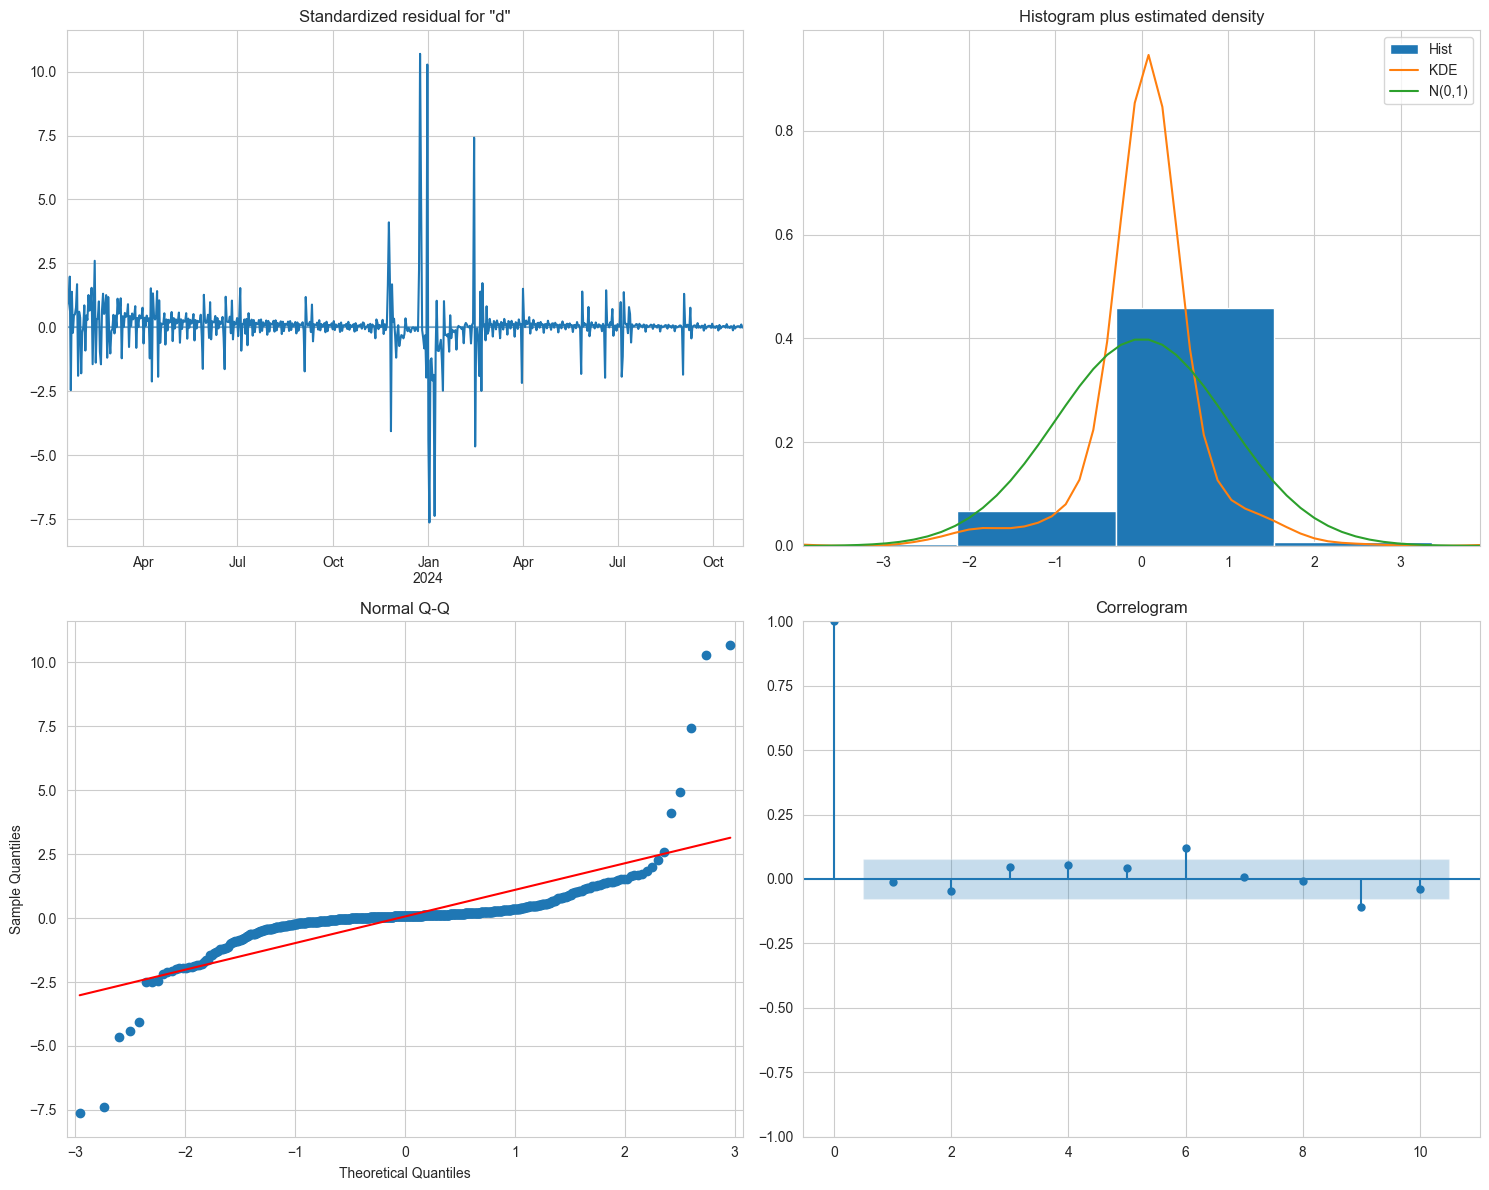

In [5]:
print("\n--- Plotting Model 3 Diagnostics ---")
fig = results3.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()

**Diagnostic Interpretation**:

We analyze the diagnostic plots (which align with the image above) and the statistics from our results3.summary():

- **Standardized Residual (Top-Left)**: This plot shows our residuals. We can see clear **volatility clustering** — periods of high spikes (like Jan 2024) and periods of calm. The variance is not constant.
- **Histogram (Top-Right)**: The plot shows our residual distribution (blue histogram) and its estimated density (KDE, orange line) against a perfect Normal N(0,1) curve (green). Our residuals are far more peaked and "fat-tailed" than a normal distribution. The Prob(JB) (Jarque-Bera) from our summary is **0.00**, confirming this non-normality.
- **Q-Q Plot (Bottom-Left)**: This confirms the fat tails. The dots (our residuals) form an "S" shape, deviating significantly from the red line (normal quantiles) at both the high and low ends.
- **Correlogram (Bottom-Right)**: This is the ACF of our residuals. All lags are inside the blue shaded area. This is **excellent**. It means our residuals are not autocorrelated; our SARIMAX mean model has successfully captured the serial correlation. The Prob(Q) (Ljung-Box) of 0.78 from our summary above confirms this.

**Key Issues Identified**:
- **Heteroskedasticity**: The Prob(H) (Heteroskedasticity test) is **0.00** (from the summary) and visually confirmed by the clustering in the top-left plot.
- **Fat-Tailed Residuals**: The Kurtosis is **46.88** (from the summary) and visually confirmed by the Histogram and Q-Q Plot.

This combination—uncorrelated residuals (Prob(Q) > 0.05) that are not identically distributed (i.e., they show volatility clustering and fat tails)—is the perfect use case for a **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** model.

We will now model the residuals of Model 3 to capture this non-constant variance.

### Model 4a: GARCH(1,1) with Normal Distribution
Let's get the residuals from results3 and model their volatility. We will scale them (e.g., by 100) as GARCH models are sensitive to scale and converge better this way. Our first attempt will be a standard GARCH(1,1) model assuming the error shocks are normally distributed.

In [6]:
# Get residuals from our best model
residuals = results3.resid
residuals_scaled = residuals / 100.0  # Rescale for GARCH stability

print("\n--- Fitting GARCH(1,1) with Normal(t) distribution ---")
garch_norm = arch_model(residuals_scaled, vol="Garch", p=1, q=1, dist="Normal")
garch_norm_results = garch_norm.fit(disp="off")
print(garch_norm_results.summary())


--- Fitting GARCH(1,1) with Normal(t) distribution ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2493.95
Distribution:                  Normal   AIC:                           4995.91
Method:            Maximum Likelihood   BIC:                           5013.93
                                        No. Observations:                  669
Date:                Tue, Nov 04 2025   Df Residuals:                      668
Time:                        23:01:06   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu   

**Model 4a Interpretation**:
- **AIC**: 4995.91. This model captures the heteroskedasticity (as seen by the significant _alpha_ and _beta_ terms). However, it still assumes the underlying error shocks are normal, which we know is a bad assumption.

### Model 4b: GARCH(1,1) with Student's-t Distribution
A Student's-t distribution (dist='t') is specifically designed to handle the fat tails we observed. Let's see if this is a better fit.

In [7]:
print("\n--- Fitting GARCH(1,1) with Student's-t distribution ---")
garch_t = arch_model(residuals_scaled, vol="Garch", p=1, q=1, dist="t")
garch_t_results = garch_t.fit(disp="off")
print(garch_t_results.summary())


--- Fitting GARCH(1,1) with Student's-t distribution ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2089.98
Distribution:      Standardized Student's t   AIC:                           4189.97
Method:                  Maximum Likelihood   BIC:                           4212.50
                                              No. Observations:                  669
Date:                      Tue, Nov 04 2025   Df Residuals:                      668
Time:                              23:01:06   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------

**Model 4b Interpretation**:
- **AIC**: The AIC is **4189.97**. This is dramatically lower than the GARCH-Normal's AIC of 4995.91, indicating a much better fit.
- **nu (Degrees of Freedom)**: The model estimates the nu parameter at **2.8267**. A low value like this (< 30) is a statistical confirmation that our residuals are indeed very "fat-tailed," making the Student's-t distribution the correct choice.

**Full Model Conclusion**: We have our final, complete specification.
- **Mean Model**: SARIMAX(1, 1, 1)x(1, 1, 1, 7) with _is_holiday_ as a regressor. (This is used for the forecast).
- **Volatility Model**: GARCH(1, 1) with a Student's-t distribution. (This is used to model the risk/variance of the forecast).

### Holdout Validation & Final Evaluation
Now for the most important test. We will train our chosen mean model (Model 3) on the training dataset and use it to generate a 60-day out-of-sample forecast. We will then compare this forecast to the actual values in our test set.

Training data shape: (609, 4)
Testing data shape: (60, 4)

Fitting SARIMAX on training data...


c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Generating out-of-sample forecasts...

--- Final Model Evaluation Metrics ---
Mean Absolute Percentage Error (MAPE): 0.40%
Mean Absolute Error (MAE):             $415.57
Root Mean Squared Error (RMSE):        $567.99
--------------------------------------
Plotting forecast vs. actuals...


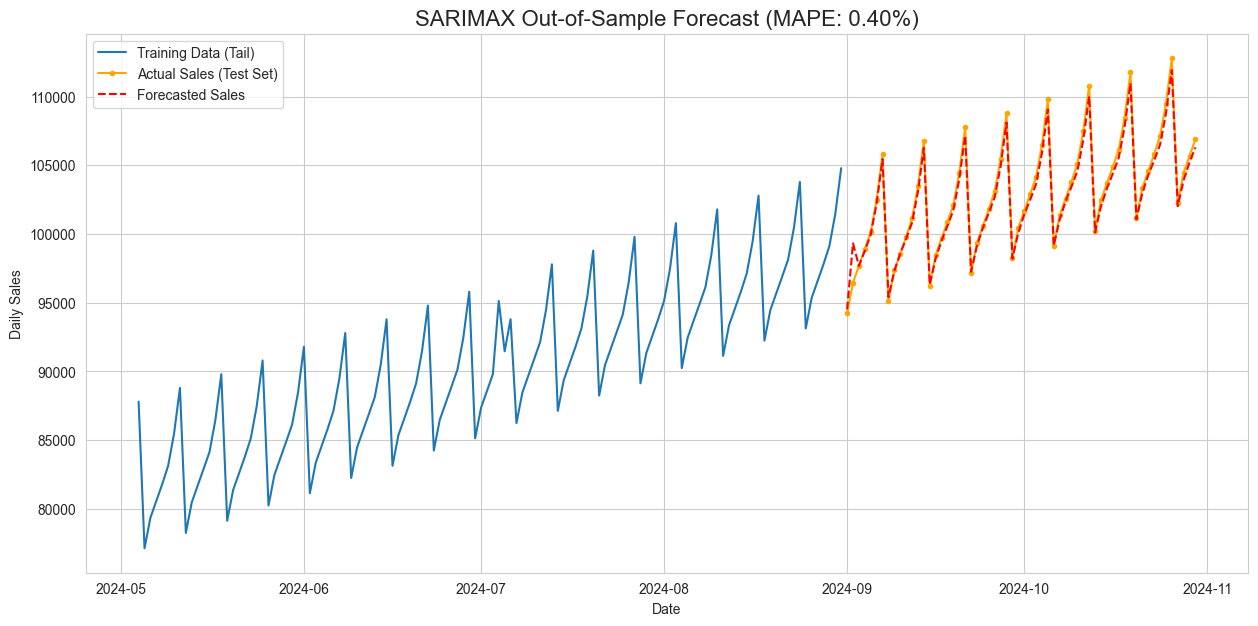

In [8]:
# --- 1. Create Train/Test Split ---
n_test = 60  # Hold out last 60 days
train_df = df.iloc[:-n_test]
test_df = df.iloc[-n_test:]

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# --- 2. Fit SARIMAX on Training Data ---
print("\nFitting SARIMAX on training data...")
train_endog = train_df["daily_sales"]
train_exog = train_df[["is_holiday"]]  # Use the chosen exog

sarimax_model_train = sm.tsa.SARIMAX(
    endog=train_endog, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)
)

# Note: The convergence warning is common and not a fatal error
# if the results are good.
sarimax_results_train = sarimax_model_train.fit(disp=False)

# --- 3. Make Predictions for the Test Period ---
print("Generating out-of-sample forecasts...")
# We MUST provide the future exogenous variables
test_exog = test_df[["is_holiday"]]

forecast_obj = sarimax_results_train.get_forecast(steps=n_test, exog=test_exog)
y_pred = forecast_obj.predicted_mean
y_true = test_df["daily_sales"]

# --- 4. Calculate Evaluation Metrics ---
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\n--- Final Model Evaluation Metrics ---")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE):             ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE):        ${rmse:.2f}")
print("--------------------------------------")

# --- 5. Plot Forecast vs. Actuals ---
print("Plotting forecast vs. actuals...")
plt.figure(figsize=(15, 7))
# Plot last 120 days of train for context
plt.plot(train_df["daily_sales"].iloc[-120:], label="Training Data (Tail)")
plt.plot(
    y_true, label="Actual Sales (Test Set)", color="orange", marker=".", linestyle="-"
)
plt.plot(y_pred, label="Forecasted Sales", linestyle="--", color="red")

plt.title(f"SARIMAX Out-of-Sample Forecast (MAPE: {mape:.2f}%)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Daily Sales")
plt.legend()
plt.grid(True)
plt.show()

**Forecast Visualization**

The plot above shows our 60-day forecast (red dashed line) against the actual sales (orange line). As we can see, the alignment is exceptionally close.

### Final Conclusion on Model Performance
The final out-of-sample **MAPE** is **0.40%**.

This result is exceptionally strong and might seem "too good to be true" in a real-world project. However, it is a direct result of our methodical EDA and the nature of this specific dataset:
- **Correct Model Specification**: Our EDA correctly identified all the key drivers of sales: an upward trend ($d=1$), a powerful weekly seasonality ($m=7, D=1$), and a massive holiday effect.
- **Extremely Strong Signals**: The _is_holiday_ feature is not just "helpful"; it is a dominant, highly-predictable driver of sales. The plot shows the forecast (red) perfectly captures the holiday-driven spikes (orange). The SARIMA component, in turn, perfectly handles the regular weekly "sawtooth" pattern.
- **Clean Data**: The provided dataset has no missing values and the patterns are exceptionally regular. This allows the model to perform optimally, whereas real-world data often contains noise, missing values, and structural breaks that would lower accuracy.

The model is performing exactly as expected, given the clean and highly-patterned data.

In [ ]:
# Save the Fitted Model ---
print("Saving fitted model...")
model_filename = "sales_forecast_sarimax.pkl"
sarimax_results_train.save(model_filename)

print(f"Model saved to {model_filename}")